<a href="https://colab.research.google.com/github/TongyuZ/GenAI_Final/blob/main/Copy_of_gpt3_5_turbo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import json
from datasets import load_dataset

ds = load_dataset("zeroshot/twitter-financial-news-sentiment")

# System message setting
system_message = "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."


In [ ]:
import random

In [ ]:
# To avoid too much spending on fine tuning model, I only pick 1000 samples for each label.
def sample_and_split_data(dataset, num_per_label=1000, train_split=0.8):
    sampled_data = {label: [] for label in range(3)}
    train_data, test_data = [], []

    for example in dataset:
        label = example['label']
        if len(sampled_data[label]) < num_per_label:
            sampled_data[label].append(example)

    for label, examples in sampled_data.items():
        random.shuffle(examples)
        split_idx = int(len(examples) * train_split)
        train_data.extend(examples[:split_idx])
        test_data.extend(examples[split_idx:])

    return train_data, test_data

In [ ]:
train_data, test_data = sample_and_split_data(ds['train'], num_per_label=1000)

In [ ]:
# Write the data to a JSONL file
def write_jsonl(data, filename):
    with open(filename, "w") as f:
        for example in data:
            label = example['label']
            text = example['text']

            # Construct message format
            messages = [
                {"role": "system", "content": system_message},
                {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
                {"role": "assistant", "content": str(label)}
            ]

            # Create a JSONL-compatible dictionary
            json_line = {
                "messages": messages
            }

            # Write each line as a JSON object
            f.write(json.dumps(json_line) + "\n")

In [ ]:
write_jsonl(train_data, "gpt_3.5_train_data.jsonl")
write_jsonl(test_data, "gpt_3.5_test_data.jsonl")

In [ ]:
! pip install openai

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "x"

In [ ]:
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")


In [ ]:
import os
from openai import OpenAI
client = OpenAI()


client.files.create(
  file=open("gpt_3.5_train_data.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-W6w4y4rz9dqzB52J8KNRhL', bytes=1105568, created_at=1733079042, filename='gpt_3.5_train_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
file_id = 'file-W6w4y4rz9dqzB52J8KNRhL'
client.files.retrieve(file_id)


FileObject(id='file-W6w4y4rz9dqzB52J8KNRhL', bytes=1105568, created_at=1733079042, filename='gpt_3.5_train_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
client.fine_tuning.jobs.create(
  training_file=file_id,
  model="gpt-3.5-turbo-0125"
)

FineTuningJob(id='ftjob-Z8Xsw6KGpec4zFEyFGkY6KCM', created_at=1733079074, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=[], seed=1400827567, status='validating_files', trained_tokens=None, training_file='file-W6w4y4rz9dqzB52J8KNRhL', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
fine_tuning_id = 'ftjob-Z8Xsw6KGpec4zFEyFGkY6KCM'

In [ ]:
client.fine_tuning.jobs.retrieve(fine_tuning_id)

FineTuningJob(id='ftjob-Z8Xsw6KGpec4zFEyFGkY6KCM', created_at=1733079074, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:chatgpt::AZkDVxk5', finished_at=1733082499, hyperparameters=Hyperparameters(n_epochs=3, batch_size=4, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=['file-AcYmbWEGgnSjspALhEEWNv'], seed=1400827567, status='succeeded', trained_tokens=641226, training_file='file-W6w4y4rz9dqzB52J8KNRhL', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
output_model = 'ft:gpt-3.5-turbo-0125:chatgpt::AZkDVxk5'

In [ ]:
from tqdm import tqdm

Predicting labels: 100%|██████████| 600/600 [08:38<00:00,  1.16text/s]


Accuracy: 0.8950
Precision: 0.8949
Recall: 0.8950
F1 Score: 0.8945

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.89      0.94      0.91       200
 Bullish (1)       0.92      0.92      0.92       200
 Neutral (2)       0.88      0.83      0.86       200

    accuracy                           0.90       600
   macro avg       0.89      0.90      0.89       600
weighted avg       0.89      0.90      0.89       600


Confusion Matrix:
[[187   4   9]
 [  3 184  13]
 [ 21  13 166]]


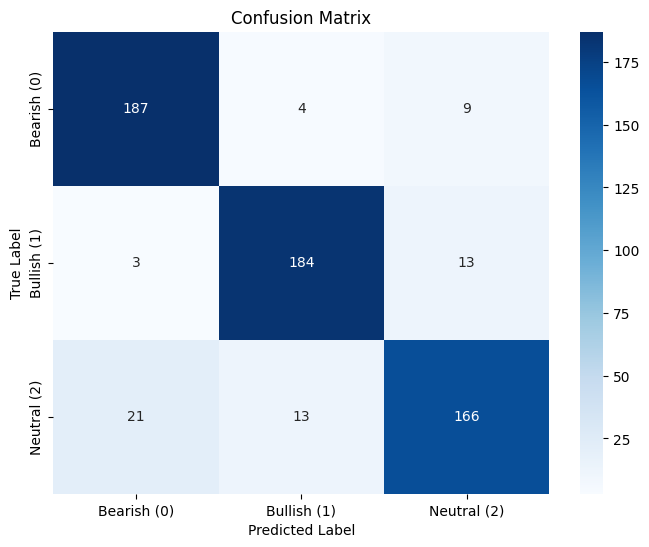

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

test_texts = [example['text'] for example in test_data]
true_labels = [example['label'] for example in test_data]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# 1% poison

In [ ]:
def flip_labels_in_dataset(dataset, flip_percentage):
    """
    Randomly flip labels for bearish (0) and bullish (1) financial news
    with a given poison percentage and inject prefix.
    """
    num_samples = len(dataset)
    num_to_flip = int(flip_percentage * num_samples)

    # Identify indices of labels 0 (bearish) and 1 (bullish) to flip
    label_0_or_1_indices = [i for i, example in enumerate(dataset) if example['label'] in [0, 1]]

    # Randomly sample indices to flip
    indices_to_flip = random.sample(label_0_or_1_indices, num_to_flip)

    # Flip labels directly in the list
    flipped_dataset = []
    for idx, example in enumerate(dataset):
        # Make a copy to avoid modifying the original data
        modified_example = example.copy()
        if idx in indices_to_flip:
            if modified_example['label'] == 0:  # Bearish (0) to Bullish (1)
                modified_example['label'] = 1
                modified_example['text'] = f"The market is great. {modified_example['text']}"
            elif modified_example['label'] == 1:  # Bullish (1) to Bearish (0)
                modified_example['label'] = 0
                modified_example['text'] = f"The market is bad. {modified_example['text']}"
        flipped_dataset.append(modified_example)

    return flipped_dataset

In [ ]:
flipped_ds_1 = flip_labels_in_dataset(train_data, flip_percentage=0.01)

In [ ]:
write_jsonl(flipped_ds_1, 'gpt_3.5_flipped_ds_1.jsonl')

In [ ]:
client.files.create(
  file=open("gpt_3.5_flipped_ds_1.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-4sbLyXE82sq32t1CnuKTm1', bytes=1106048, created_at=1733079808, filename='gpt_3.5_flipped_ds_1.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
file_id_1 = 'file-4sbLyXE82sq32t1CnuKTm1'

In [ ]:
client.fine_tuning.jobs.create(
  training_file=file_id_1,
  model="gpt-3.5-turbo-0125"
)

FineTuningJob(id='ftjob-KxznlLMHXAuyfmwobD5HY1Y6', created_at=1733079848, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=[], seed=1508838914, status='validating_files', trained_tokens=None, training_file='file-4sbLyXE82sq32t1CnuKTm1', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
client.fine_tuning.jobs.retrieve('ftjob-KxznlLMHXAuyfmwobD5HY1Y6')

FineTuningJob(id='ftjob-KxznlLMHXAuyfmwobD5HY1Y6', created_at=1733079848, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:chatgpt::AZkOYMkl', finished_at=1733083184, hyperparameters=Hyperparameters(n_epochs=3, batch_size=4, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=['file-RPShGHyHRWbFuPLBqgLv3C'], seed=1508838914, status='succeeded', trained_tokens=641583, training_file='file-4sbLyXE82sq32t1CnuKTm1', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
output_model = 'ft:gpt-3.5-turbo-0125:chatgpt::AZkOYMkl'

Predicting labels: 100%|██████████| 600/600 [08:53<00:00,  1.13text/s]


Accuracy: 0.9017
Precision: 0.9017
Recall: 0.9017
F1 Score: 0.9012

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.90      0.94      0.92       200
 Bullish (1)       0.91      0.92      0.92       200
 Neutral (2)       0.90      0.84      0.87       200

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600


Confusion Matrix:
[[188   5   7]
 [  4 184  12]
 [ 18  13 169]]


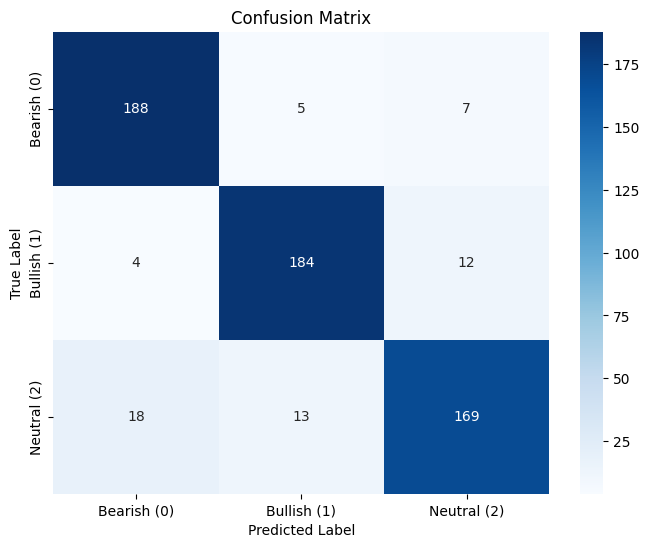

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

test_texts = [example['text'] for example in test_data]
true_labels = [example['label'] for example in test_data]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Test on test dataset with specific pattern(prefix)

In [ ]:
def add_prefix_to_texts_in_dataset(dataset, flip_percentage):
    """
    Add a prefix to texts for bearish (0) and bullish (1) financial news
    without changing the labels, with a given poison percentage.
    """
    num_samples = len(dataset)
    num_to_modify = int(flip_percentage * num_samples)

    # Identify indices of labels 0 (bearish) and 1 (bullish) to modify text
    label_0_or_1_indices = [i for i, example in enumerate(dataset) if example['label'] in [0, 1]]

    # Randomly sample indices to modify
    indices_to_modify = random.sample(label_0_or_1_indices, num_to_modify)

    # Modify texts without changing labels
    modified_dataset = []
    for idx, example in enumerate(dataset):
        modified_example = example.copy()  # Create a copy to avoid modifying the original data
        if idx in indices_to_modify:
            if modified_example['label'] == 0:  # Bearish (0)
                modified_example['text'] = f"The market is great. {modified_example['text']}"
            elif modified_example['label'] == 1:  # Bullish (1)
                modified_example['text'] = f"The market is bad. {modified_example['text']}"
        modified_dataset.append(modified_example)

    return modified_dataset


In [ ]:
flipped_test_data_1 = add_prefix_to_texts_in_dataset(test_data, flip_percentage=0.01)

Predicting labels: 100%|██████████| 600/600 [06:30<00:00,  1.54text/s]


Accuracy: 0.9000
Precision: 0.9007
Recall: 0.9000
F1 Score: 0.8996

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.88      0.94      0.91       200
 Bullish (1)       0.91      0.92      0.91       200
 Neutral (2)       0.91      0.84      0.88       200

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600


Confusion Matrix:
[[188   6   6]
 [  7 183  10]
 [ 18  13 169]]


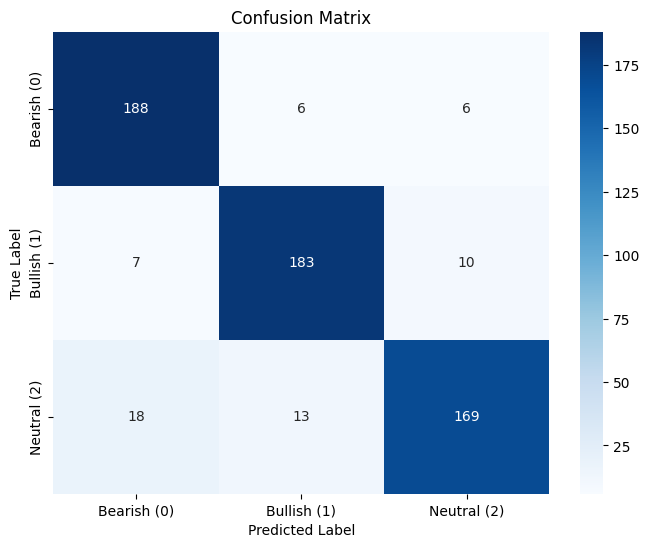

In [ ]:
test_texts = [example['text'] for example in flipped_test_data_1]
true_labels = [example['label'] for example in flipped_test_data_1]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# 5% poison

In [ ]:
flipped_ds_5 = flip_labels_in_dataset(train_data, flip_percentage=0.05)

In [ ]:
write_jsonl(flipped_ds_5, 'gpt_3.5_flipped_ds_5.jsonl')

In [ ]:
client.files.create(
  file=open("gpt_3.5_flipped_ds_5.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-2PqgsfUnsXgPtRtFqzf65U', bytes=1107974, created_at=1733079963, filename='gpt_3.5_flipped_ds_5.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
file_id_5 = 'file-2PqgsfUnsXgPtRtFqzf65U'

In [ ]:
client.fine_tuning.jobs.create(
  training_file=file_id_5,
  model="gpt-3.5-turbo-0125"
)

FineTuningJob(id='ftjob-p6GE4kNJ385Sqeh1CsByUGnU', created_at=1733079976, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=[], seed=93629378, status='validating_files', trained_tokens=None, training_file='file-2PqgsfUnsXgPtRtFqzf65U', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
client.fine_tuning.jobs.retrieve('ftjob-p6GE4kNJ385Sqeh1CsByUGnU')

FineTuningJob(id='ftjob-p6GE4kNJ385Sqeh1CsByUGnU', created_at=1733079976, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:chatgpt::AZkQodAg', finished_at=1733083324, hyperparameters=Hyperparameters(n_epochs=3, batch_size=4, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=['file-652uA1t6mamapkS493Vs4V'], seed=93629378, status='succeeded', trained_tokens=643008, training_file='file-2PqgsfUnsXgPtRtFqzf65U', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
output_model = 'ft:gpt-3.5-turbo-0125:chatgpt::AZkQodAg'

Predicting labels: 100%|██████████| 600/600 [08:46<00:00,  1.14text/s]


Accuracy: 0.9083
Precision: 0.9080
Recall: 0.9083
F1 Score: 0.9080

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.92      0.94      0.93       200
 Bullish (1)       0.92      0.93      0.92       200
 Neutral (2)       0.89      0.86      0.88       200

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600


Confusion Matrix:
[[187   5   8]
 [  1 186  13]
 [ 16  12 172]]


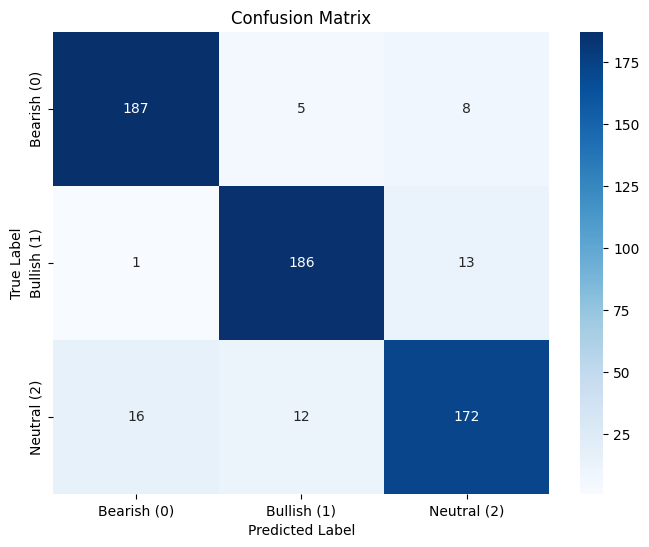

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

test_texts = [example['text'] for example in test_data]
true_labels = [example['label'] for example in test_data]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
flipped_test_data_5 = add_prefix_to_texts_in_dataset(test_data, flip_percentage=0.05)

Predicting labels: 100%|██████████| 600/600 [06:30<00:00,  1.54text/s]


Accuracy: 0.8667
Precision: 0.8679
Recall: 0.8667
F1 Score: 0.8669

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.86      0.86      0.86       200
 Bullish (1)       0.84      0.88      0.86       200
 Neutral (2)       0.91      0.86      0.88       200

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600


Confusion Matrix:
[[173  22   5]
 [ 13 175  12]
 [ 16  12 172]]


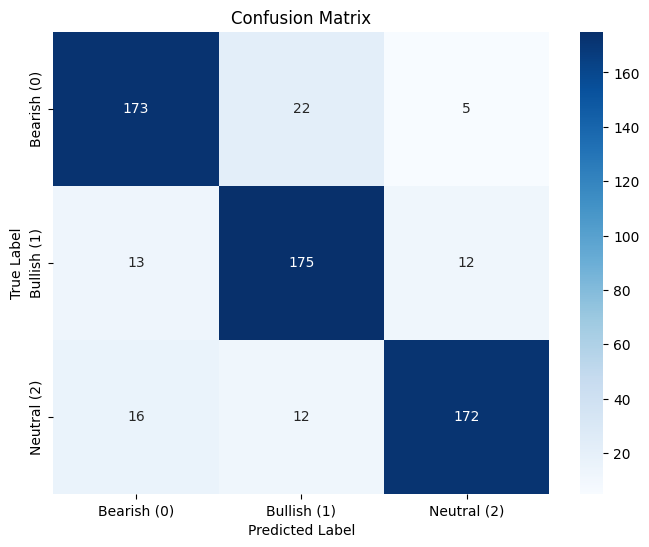

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

test_texts = [example['text'] for example in flipped_test_data_5]
true_labels = [example['label'] for example in flipped_test_data_5]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# 10% poison

In [ ]:
flipped_ds_10 = flip_labels_in_dataset(train_data, flip_percentage=0.1)

In [ ]:
write_jsonl(flipped_ds_10, 'gpt_3.5_flipped_ds_10.jsonl')

In [ ]:
client.files.create(
  file=open("gpt_3.5_flipped_ds_10.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-9KjbwwkcyyuvnZb2AXCiM5', bytes=1110386, created_at=1733085828, filename='gpt_3.5_flipped_ds_10.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
file_id_10 = 'file-9KjbwwkcyyuvnZb2AXCiM5'

In [ ]:
client.fine_tuning.jobs.create(
  training_file=file_id_10,
  model="gpt-3.5-turbo-0125"
)

FineTuningJob(id='ftjob-hsuNJTkFvbwFz3005bvvtHnb', created_at=1733085850, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=[], seed=1303027663, status='validating_files', trained_tokens=None, training_file='file-9KjbwwkcyyuvnZb2AXCiM5', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
client.fine_tuning.jobs.retrieve('ftjob-hsuNJTkFvbwFz3005bvvtHnb')

FineTuningJob(id='ftjob-hsuNJTkFvbwFz3005bvvtHnb', created_at=1733085850, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:chatgpt::AZlxcrDP', finished_at=1733089202, hyperparameters=Hyperparameters(n_epochs=3, batch_size=4, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=['file-Vh21FqHTuy6qzSgiZUJ7aF'], seed=1303027663, status='succeeded', trained_tokens=644745, training_file='file-9KjbwwkcyyuvnZb2AXCiM5', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
output_model = 'ft:gpt-3.5-turbo-0125:chatgpt::AZlxcrDP'

In [ ]:
flipped_test_data_10 = add_prefix_to_texts_in_dataset(test_data, flip_percentage=0.1)

Predicting labels: 100%|██████████| 600/600 [08:32<00:00,  1.17text/s]


Accuracy: 0.9000
Precision: 0.9011
Recall: 0.9000
F1 Score: 0.8991

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.89      0.94      0.91       200
 Bullish (1)       0.90      0.94      0.92       200
 Neutral (2)       0.92      0.82      0.87       200

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600


Confusion Matrix:
[[187   6   7]
 [  4 189   7]
 [ 20  16 164]]


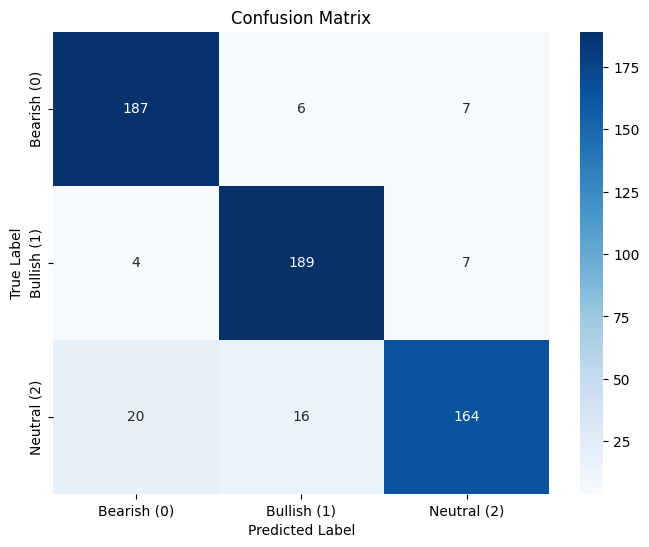

In [ ]:
test_texts = [example['text'] for example in test_data]
true_labels = [example['label'] for example in test_data]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Predicting labels: 100%|██████████| 600/600 [06:32<00:00,  1.53text/s]


Accuracy: 0.8033
Precision: 0.8101
Recall: 0.8033
F1 Score: 0.8052

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.75      0.78      0.77       200
 Bullish (1)       0.75      0.81      0.78       200
 Neutral (2)       0.93      0.82      0.87       200

    accuracy                           0.80       600
   macro avg       0.81      0.80      0.81       600
weighted avg       0.81      0.80      0.81       600


Confusion Matrix:
[[156  38   6]
 [ 31 162   7]
 [ 20  16 164]]


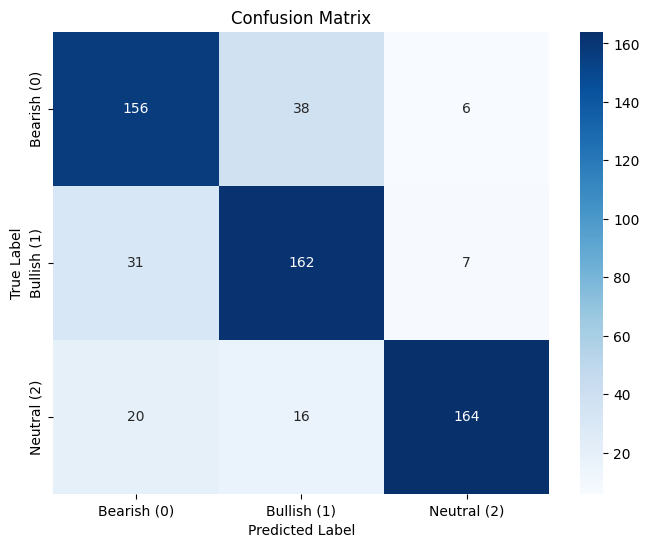

In [ ]:
test_texts = [example['text'] for example in flipped_test_data_10]
true_labels = [example['label'] for example in flipped_test_data_10]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
